# XGBoost Ensemble with Adversial validation ponderation 

## Instructions
 -  Datas are in the files Datasets
 - The final submission file is FinalSubmission.csv and will be generated after running this notebook

### Importing libraries

In [1]:
# dataframe and plotting
import os, sys, time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from itertools import chain

In [3]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score,mean_absolute_error

In [4]:
from xgboost import XGBClassifier

In [5]:
#import optuna

### 1. Load the dataset

In [6]:
# Load files into a pandas dataframe
data_path= 'Datasets/'
train = pd.read_csv(data_path+'Train.csv')
test = pd.read_csv(data_path+'Test.csv')
ss = pd.read_csv(data_path+'SampleSubmission.csv')
variables = pd.read_csv(data_path+'VariableDefinitions.csv')

In [7]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


### 2. Dataset processing


In [8]:

# Convert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']



In [9]:
# Pre-processing thanks to the starting notebook of the competition
def preprocessing_data(data, data_test):
    
    # Convert the following numerical features from interger to float
    data[["household_size", "age_of_respondent" ]] = data[["household_size", "age_of_respondent"]].values.astype(float)
    data_test[["household_size", "age_of_respondent"]] = data_test[["household_size", "age_of_respondent"]].values.astype(float)
    
    # year here is categorical 
    data[["year"]] = data[["year"]].values.astype(str)
    data_test[["year"]] = data_test[["year"]].values.astype(str)
    
    # categorical features to be onverted to One Hot Encoding (OHE)
    categ = ["year",
             "relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"
            ]
    ## we don't have hight so OHE should be enought
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    data_test = pd.get_dummies(data_test, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion for binary features
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    data_test["location_type"] = le.fit_transform(data_test["location_type"])
    data_test["cellphone_access"] = le.fit_transform(data_test["cellphone_access"])
    data_test["gender_of_respondent"] = le.fit_transform(data_test["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    data_test = data_test.drop(["uniqueid"], axis=1)
    
    features = list(data_test.columns)
    data_test = data_test[features]
    
    return features, data, data_test                 

In [10]:
features, processed_train, processed_test = preprocessing_data(X_train, test)

In [11]:
processed_train = processed_train.values
processed_test = processed_test.values

### Split data 
We use 5 Stratied Fold validation 

In [12]:
k =5
Sf= StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
datasets = [(processed_train[train_index], processed_train[test_index],y_train[train_index], y_train[test_index]) for train_index,test_index in Sf.split(processed_train, y_train) ]

In [13]:
[len(X_test_) for X_train_, X_test_, Y_train_, Y_test_ in datasets]

[4705, 4705, 4705, 4705, 4704]

### 4. Model Building and Experiments

In [14]:
static_params = {
                 'random_state':42,
                 'objective': 'binary:logistic',
                 'n_jobs': -1

}

In [15]:
def builModel(opt_params):
    # update with static params
    opt_params.update(static_params)
    model_xgb = XGBClassifier(**opt_params)
    return model_xgb

In [16]:
## run over all the data:
exp_time = time.time()
val_values = [] 
val_values_aucpr = []
N_estimors = []
pred_final_sum = np.zeros(len(test))
preds_OOF = []
y_true_00F = []
pred_final = []
Best_params = []
adv_aucs = []
for ind, (X_train_, X_test_, Y_train_, Y_test_) in enumerate(datasets):
    print('Fold:', ind, '-------------------------')
    if ind==0:
        # Here our best Hyperparameters 
        best_p = {'eta': 0.05012583543681726, 'max_depth': 5, 'colsample_bytree': 0.7, 'subsample': 0.7, 'n_estimators': 1300, 'min_child_weight': 35}
        Best_params.append(best_p)
    
    xgb_model = builModel(best_p)
    eval_set = [(X_train_, Y_train_), (X_test_, Y_test_)] 
    xgb_model.fit(X_train_, Y_train_, eval_metric=['auc','aucpr'], eval_set=eval_set, verbose=0)
    
    n_estimors = np.argmax(xgb_model.evals_result_['validation_1']['auc'])
    best_aucroc = xgb_model.evals_result_['validation_1']['auc'][n_estimors]
    best_aurpr = xgb_model.evals_result_['validation_1']['aucpr'][n_estimors]
    
    preds_OOF_tmp = xgb_model.predict_proba(X_test_, ntree_limit = int(n_estimors))
    preds_OOF.append(list(preds_OOF_tmp[:,1]))
     
    y_true_00F.append(list(Y_test_))
    
    pred_final_tmp = xgb_model.predict_proba(processed_test, ntree_limit = int(n_estimors))
    pred_final.append(list(pred_final_tmp[:,1]))
    pred_final_sum = pred_final_sum+pred_final_tmp[:,1]
    N_estimors.append(n_estimors)
    val_values.append(best_aucroc)
    val_values_aucpr.append(best_aurpr)
    
    #### Adversarial check 
    
    X = np.concatenate((X_train_, processed_test))
    y = np.concatenate((np.zeros(len(X_train_)), np.ones(len(processed_test))) )
    
    best_p_adv = best_p
    best_p_adv['n_estimators'] = n_estimors
    xgb_model_adv = builModel(best_p_adv)
    xgb_model_adv.fit(X, y, eval_metric=['auc'], eval_set=eval_set, verbose=0)
    adv_aucs.append(max(xgb_model_adv.evals_result_['validation_0']['auc']))
 
    
    print(f"epoch = {n_estimors}--AUCROC perf = {best_aucroc} -- AUCPR perf = {best_aurpr}")
    exp_time = time.time()-exp_time
print('End----- time ',exp_time, 's')

Fold: 0 -------------------------
epoch = 236--AUCROC perf = 0.866189 -- AUCPR perf = 0.57346
Fold: 1 -------------------------
epoch = 220--AUCROC perf = 0.863207 -- AUCPR perf = 0.586027
Fold: 2 -------------------------
epoch = 219--AUCROC perf = 0.874046 -- AUCPR perf = 0.616711
Fold: 3 -------------------------
epoch = 214--AUCROC perf = 0.860689 -- AUCPR perf = 0.569543
Fold: 4 -------------------------
epoch = 211--AUCROC perf = 0.863008 -- AUCPR perf = 0.579722
End----- time  16.370975255966187 s


In [17]:
adv_aucs

[0.551212, 0.568535, 0.592413, 0.517135, 0.581008]

### 5. Out Of Bag (OOF) validation performance 

In [18]:
preds_OOF_1d = np.array(list(chain(*preds_OOF)))
y_true_00F_1d = np.array(list(chain(*y_true_00F)))

In [19]:
AUC(y_true_00F_1d, preds_OOF_1d), average_precision_score(y_true_00F_1d, preds_OOF_1d)

(0.8651001676910737, 0.5846929131304966)

In [20]:
mean_absolute_error(y_true_00F_1d,preds_OOF_1d)

0.16779583395950906

### 6. Choice of the best tresh to convert probability to binary score 

In [21]:
treshs = np.arange(0.3, 0.6, 0.005)

In [22]:
def Tresh_to_metric(y_true,pred_t, treshs):
    res = list()
    for tresh in treshs:
        pred_tresh = (pred_t>tresh).astype(int)
        res.append(mean_absolute_error(y_true,pred_tresh))
    return res

In [23]:
ress = Tresh_to_metric(y_true_00F_1d, preds_OOF_1d,treshs)

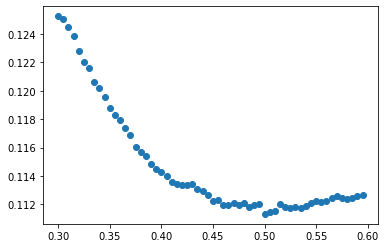

In [24]:
plt.scatter(treshs,ress);

0.50 seems to be good threshold

In [25]:
pred_tresh = (preds_OOF_1d>0.5).astype(int)

In [26]:
mean_absolute_error(y_true_00F_1d,pred_tresh)

0.11133310661452134

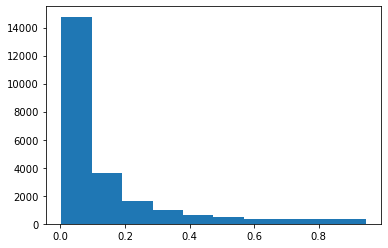

In [27]:
plt.hist(preds_OOF_1d);

### 6. Computation of ensemble ponderation coef

In [28]:
coef = np.array(adv_aucs)

In [29]:
coef

array([0.551212, 0.568535, 0.592413, 0.517135, 0.581008])

In [30]:
coefs = (1-coef)/(5-coef.sum())
coefs

array([0.20495438, 0.19704324, 0.18613854, 0.22051681, 0.19134702])

### 7. Final submission 

In [31]:
pred_f = np.zeros(len(processed_test))
                  
for i, coef in enumerate(list(coefs)):
    pred_f += coef*np.array(pred_final[i])

In [32]:
pred_f

array([0.82699703, 0.85949989, 0.0603744 , ..., 0.36065552, 0.0317991 ,
       0.0670699 ])

In [33]:
pred_final_tresh = (pred_f>0.50).astype(int)

In [34]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": pred_final_tresh})

Let’s observe the sample results from our submission DataFrame.


In [35]:
#show the five sample
submission.sample(5)

,uniqueid,bank_account
6024,uniqueid_12159 x Rwanda,0
828,uniqueid_6897 x Kenya,0
553,uniqueid_6622 x Kenya,0
6597,uniqueid_6872 x Tanzania,0
7975,uniqueid_8250 x Tanzania,0


Save results in the CSV file.


In [36]:
# Create submission csv file csv file

submission.to_csv('FinalSubmission.csv', index = False)

### Please find my final solution in FinalSubmission.csv

# Thank you!!!

### Blend with MLP (TO DO)

In [37]:
# mlp = pd.read_csv('Submissions/MLP2_CV_Tresh_bis_advserse.csv')

# pred_all = (submission_raw.bank_account+mlp.bank_account)/2
# pred_all = pred_all.values

# pred_final_tresh_all = (pred_all>0.46).astype(int)

# submission_all = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
#                            "bank_account": pred_final_tresh_all})